In [1]:
#!pip install pyyaml==5.1
import torch
import torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version

1.9.1+cu111 True
gcc (Gentoo 11.3.0 p4) 11.3.0
Copyright (C) 2021 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [2]:
#%matplotlib notebook
import glob
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from IPython.display import Image
import time
import shutil
from os import path

from shapely.geometry import Polygon

# importing required libraries
import pandas as pd
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import pandas as pd
from get_iou import get_max_iou, get_iou, get_overlap
import pickle
import random
import json
import os
from collections import Counter
import cv2
import numpy as np

import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2 import model_zoo
from detectron2.structures import BoxMode
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog
from detectron2.structures import BoxMode
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator
from detectron2.engine import DefaultTrainer

In [3]:
from metric_tablebank import metric_table_bank_union
from get_models_and_set import get_model, evaluate_models
from get_models_and_set import get_test_data_latex, get_test_data_word, get_test_data_publaynet
from get_models_and_set import get_train_data_latex, get_train_data_word, get_train_data_publaynet

# Get data

In [9]:
def get_whole_training_set():
    return get_train_data_latex() + get_train_data_word() + get_train_data_publaynet()

In [11]:
word = get_train_data_word()
latex = get_train_data_latex()
publaynet = get_train_data_publaynet()

word_test = get_test_data_word()
latex_test = get_test_data_latex()
publaynet_test = get_test_data_publaynet()

In [12]:
all_sets = [word, latex, publaynet, word_test, latex_test, publaynet_test]

for set_ in all_sets:
    count_annotation = 0
    for i in set_:
        for j in i["annotations"]:
            count_annotation += 1
    
    print("number of documents: ", len(set_))
    print("number of tables: ", count_annotation)
    print("--------------------------------------")

number of documents:  73383
number of tables:  95404
--------------------------------------
number of documents:  187199
number of tables:  237431
--------------------------------------
number of documents:  85159
number of tables:  100975
--------------------------------------
number of documents:  2281
number of tables:  2930
--------------------------------------
number of documents:  5719
number of tables:  7246
--------------------------------------
number of documents:  4988
number of tables:  6291
--------------------------------------


In [4]:
path_data = "/data/rali5/Tmp/yockelle/TableBank/TableBank/Detection/"

In [12]:
train_set_name = "my_dataset_train1"
valid_set_name = "my_dataset_valid"
test_set_name = "my_dataset_test"

# Train set
DatasetCatalog.register(train_set_name, get_whole_training_set)
MetadataCatalog.get(train_set_name).set(thing_classes=["table"])
text_metadata_train = MetadataCatalog.get(train_set_name)

"""
# Validation set
DatasetCatalog.register(valid_set_name, get_valid_data)
MetadataCatalog.get(valid_set_name).set(thing_classes=["table"])
text_metadata_valid = MetadataCatalog.get(valid_set_name)

# Test set
DatasetCatalog.register(test_set_name, get_test_data_publaynet)
MetadataCatalog.get(test_set_name).set(thing_classes=["table"])
text_metadata_test = MetadataCatalog.get(test_set_name)
"""

'\n# Validation set\nDatasetCatalog.register(valid_set_name, get_valid_data)\nMetadataCatalog.get(valid_set_name).set(thing_classes=["table"])\ntext_metadata_valid = MetadataCatalog.get(valid_set_name)\n\n# Test set\nDatasetCatalog.register(test_set_name, get_test_data_publaynet)\nMetadataCatalog.get(test_set_name).set(thing_classes=["table"])\ntext_metadata_test = MetadataCatalog.get(test_set_name)\n'

In [13]:
class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [18]:
type_ = "/word-latex-publaynet/"

cfg = get_cfg()
# "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"
# faster_rcnn_X_101_32x8d_FPN_3x.yaml
cfg.merge_from_file("/data/rali5/Tmp/yockelle/TableBank/TableBank/output/word-latex/X101/config_word-latex_X101.yaml")
#cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = (train_set_name,)
#cfg.DATASETS.TEST = ()
#cfg.DATALOADER.NUM_WORKERS = 4
cfg.DATALOADER.FILTER_EMPTY_ANNOTATIONS = False
#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("/data/rali5/Tmp/yockelle/TableBank/TableBank/output/word-latex/X152/config_word-latex_X152.yaml")  # Let training initialize from model zoo
#cfg.SOLVER.IMS_PER_BATCH = 4
#cfg.SOLVER.BASE_LR = 0.0125  # pick a good LR
#cfg.SOLVER.BASE_LR = 0.0125  # pick a good LR
#cfg.SOLVER.MAX_ITER = 3000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
#cfg.SOLVER.STEPS = []        # do not decay learning rate
#cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
#cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256
#cfg.MODEL.PANOPTIC_FPN.COMBINE.INSTANCES_CONFIDENCE_THRESH = 0.5
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.TEST.EVAL_PERIOD = 1000
CUDA_LAUNCH_BLOCKING = 1

os.makedirs(cfg.OUTPUT_DIR + type_, exist_ok=True)
#trainer = DefaultTrainer(cfg) 
trainer = CocoTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

shutil.move(cfg.OUTPUT_DIR + "/" + "model_final.pth", cfg.OUTPUT_DIR + type_ + "model_final.pth")

[06/13 13:14:03 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

X-101-32x8d.pkl: 356MB [00:12, 27.5MB/s]                              


[06/13 13:14:38 d2.checkpoint.c2_model_loading]: Renaming Caffe2 weights ......
[06/13 13:14:38 d2.checkpoint.c2_model_loading]: Following weights matched with submodule backbone.bottom_up:
| Names in Model    | Names in Checkpoint                         | Shapes                                          |
|:------------------|:--------------------------------------------|:------------------------------------------------|
| res2.0.conv1.*    | res2_0_branch2a_{bn_b,bn_rm,bn_riv,bn_s,w}  | (256,) (256,) (256,) (256,) (256,64,1,1)        |
| res2.0.conv2.*    | res2_0_branch2b_{bn_b,bn_rm,bn_riv,bn_s,w}  | (256,) (256,) (256,) (256,) (256,8,3,3)         |
| res2.0.conv3.*    | res2_0_branch2c_{bn_b,bn_rm,bn_riv,bn_s,w}  | (256,) (256,) (256,) (256,) (256,256,1,1)       |
| res2.0.shortcut.* | res2_0_branch1_{bn_b,bn_rm,bn_riv,bn_s,w}   | (256,) (256,) (256,) (256,) (256,64,1,1)        |
| res2.1.conv1.*    | res2_1_branch2a_{bn_b,bn_rm,bn_riv,bn_s,w}  | (256,) (256,) (256,) (256,) (256,2

Some model parameters or buffers are not found in the checkpoint:
backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
The checkpoint state_dict contains keys that are not used by the model:
  linear.{bias, weight}


[06/13 13:14:38 d2.engine.train_loop]: Starting training from iteration 0


/u/yockelle/anaconda3/lib/python3.8/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


ERROR [06/13 13:14:40 d2.engine.train_loop]: Exception during training:
Traceback (most recent call last):
  File "/u/yockelle/anaconda3/lib/python3.8/site-packages/detectron2/engine/train_loop.py", line 149, in train
    self.run_step()
  File "/u/yockelle/anaconda3/lib/python3.8/site-packages/detectron2/engine/defaults.py", line 494, in run_step
    self._trainer.run_step()
  File "/u/yockelle/anaconda3/lib/python3.8/site-packages/detectron2/engine/train_loop.py", line 273, in run_step
    loss_dict = self.model(data)
  File "/u/yockelle/anaconda3/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1051, in _call_impl
    return forward_call(*input, **kwargs)
  File "/u/yockelle/anaconda3/lib/python3.8/site-packages/detectron2/modeling/meta_arch/rcnn.py", line 154, in forward
    features = self.backbone(images.tensor)
  File "/u/yockelle/anaconda3/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1051, in _call_impl
    return forward_call(*input, **kwargs)
  F

RuntimeError: CUDA out of memory. Tried to allocate 2.64 GiB (GPU 0; 23.69 GiB total capacity; 7.76 GiB already allocated; 797.62 MiB free; 7.78 GiB reserved in total by PyTorch)

In [9]:
"""
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3   # set the testing threshold for this model
cfg.DATASETS.TEST = (test_set_name, )
predictor = DefaultPredictor(cfg)
"""
type_ = "/word-latex/"

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
#cfg.DATASETS.TRAIN = (train_set_name,)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR + type_, "model_final.pth")
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256
cfg.MODEL.PANOPTIC_FPN.COMBINE.INSTANCES_CONFIDENCE_THRESH = 0.5
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.TEST.EVAL_PERIOD = 1000
CUDA_LAUNCH_BLOCKING = 1
predictor = DefaultPredictor(cfg)

In [10]:
def draw_pred_and_truth(img, truths, preds):
    for truth in truths:
        x_min = int(truth[0])
        y_min = int(truth[1])
        x_max = int(truth[2])
        y_max = int(truth[3])
        cv2.rectangle(img, (x_min, y_max), (x_max, y_min), (0,0,255), 2)
    for pred in preds:
        x_min = int(pred[0])
        y_min = int(pred[1])
        x_max = int(pred[2])
        y_max = int(pred[3])
        cv2.rectangle(img, (x_min, y_max), (x_max, y_min), (255,0,0), 2)

precision:  0.43364353363129976
image name:  /data/rali5/Tmp/yockelle/TableBank/TableBank/Detection/images/hk-new-hire-form_3.jpg


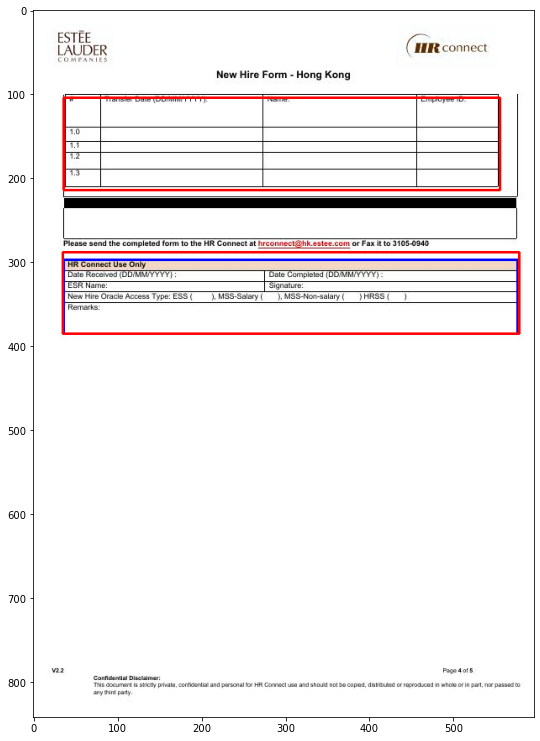

precision:  0.33810208381286005
image name:  /data/rali5/Tmp/yockelle/TableBank/TableBank/Detection/images/1-21-16_Key%20Changes_M21-1III_v_5_SecA_44.jpg


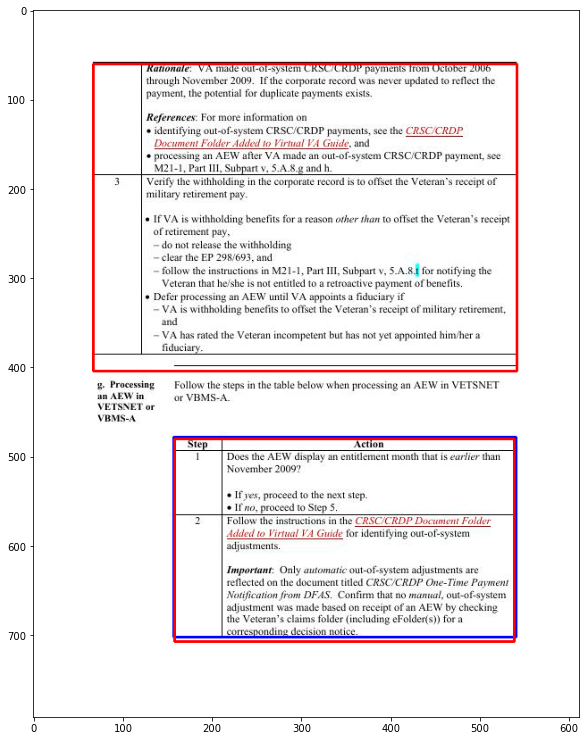

precision:  0.1067032429394157
image name:  /data/rali5/Tmp/yockelle/TableBank/TableBank/Detection/images/ems-strategic-plan_10.jpg


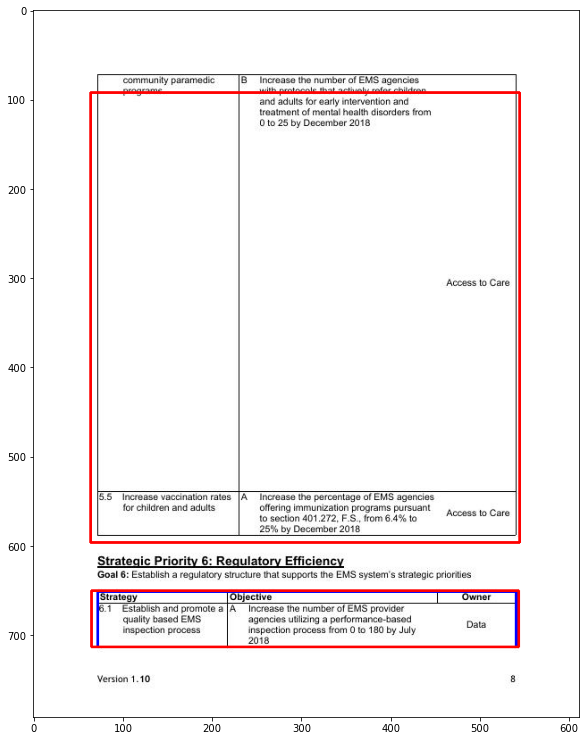

precision:  0.0
image name:  /data/rali5/Tmp/yockelle/TableBank/TableBank/Detection/images/dhs-annual-report-2011-12-full-report-web_247.jpg


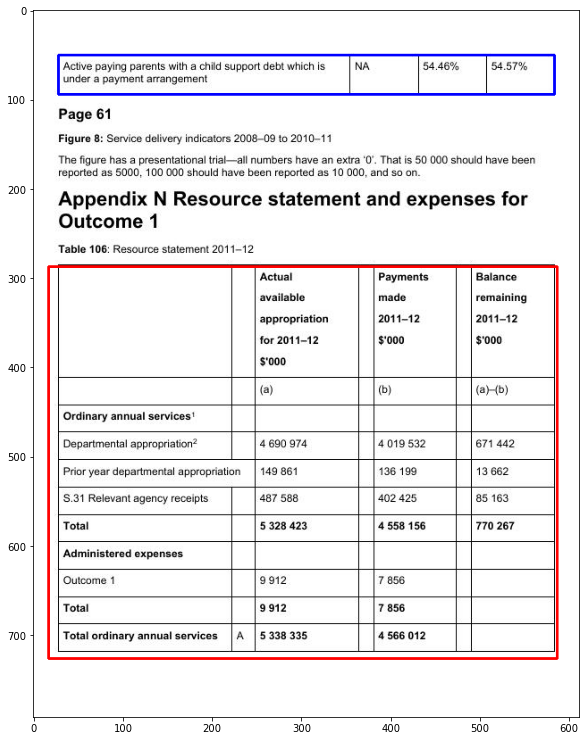

precision:  0.44657828664837346
image name:  /data/rali5/Tmp/yockelle/TableBank/TableBank/Detection/images/homework5spring2015_4.jpg


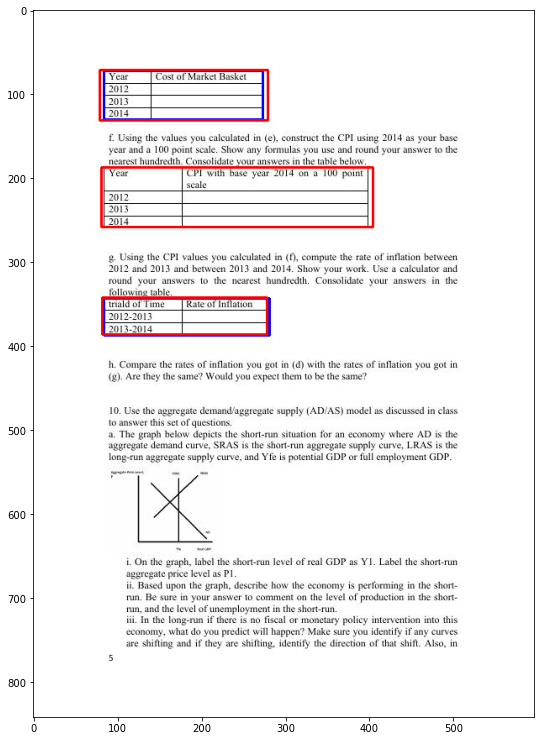

precision:  0.15120577788132622
image name:  /data/rali5/Tmp/yockelle/TableBank/TableBank/Detection/images/Joint-PiT-Registry-Survey-for-Youth_1.jpg


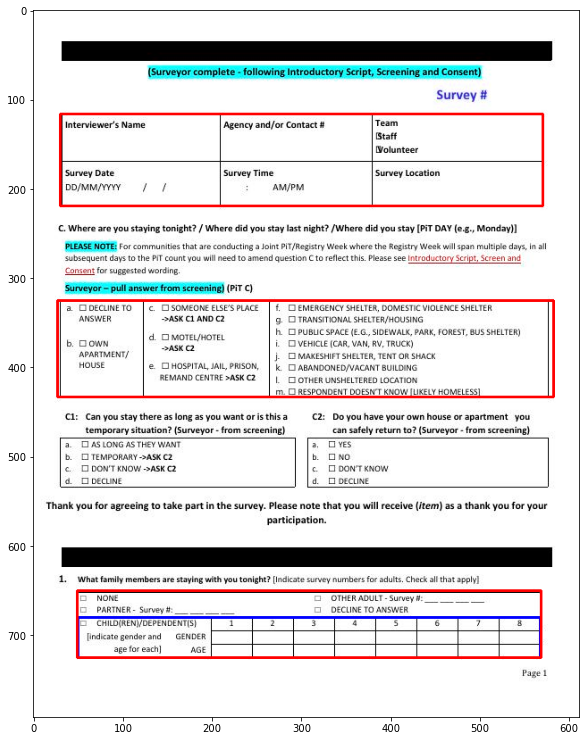

precision:  0.3581668491212973
image name:  /data/rali5/Tmp/yockelle/TableBank/TableBank/Detection/images/7-28-29_Softballnation_Rt._42_Showcase_18U_Game_Times1_0.jpg


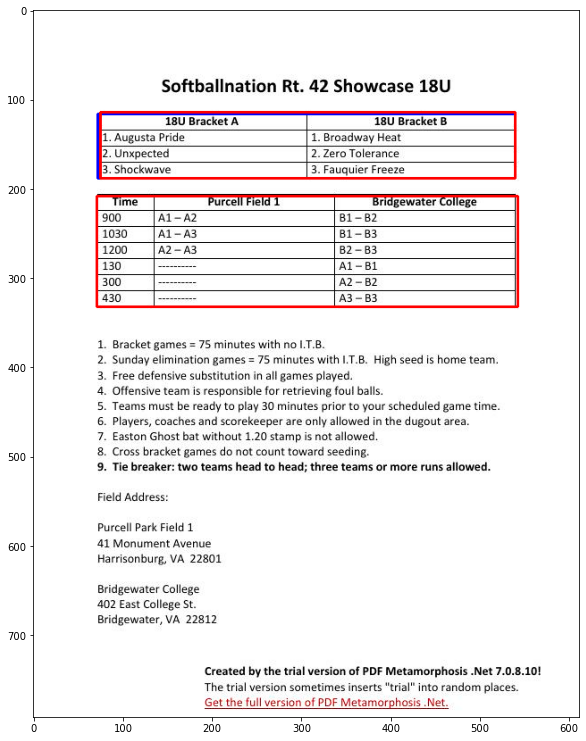

precision:  0.40136316133398664
image name:  /data/rali5/Tmp/yockelle/TableBank/TableBank/Detection/images/appendix_8_DIBP_Official_Response_Attachment_A_5.jpg


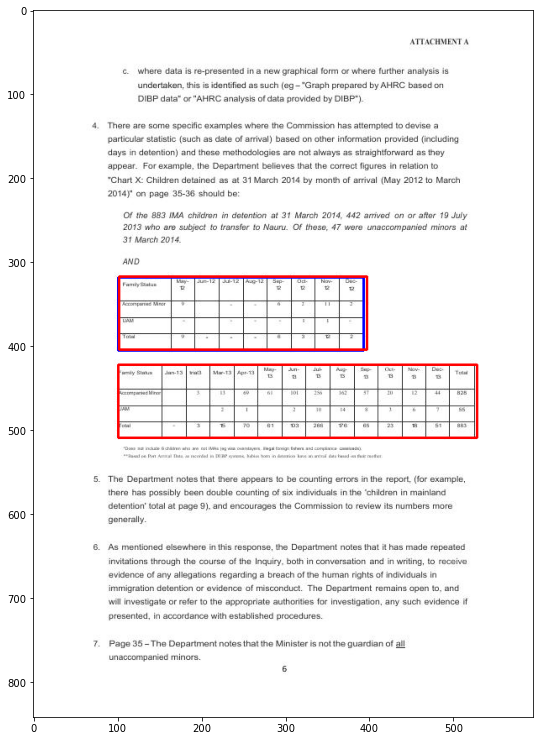

precision:  0.415145270842569
image name:  /data/rali5/Tmp/yockelle/TableBank/TableBank/Detection/images/Carbon_TIME_All_Items_List_17-18_with_ToC_Final_18.jpg


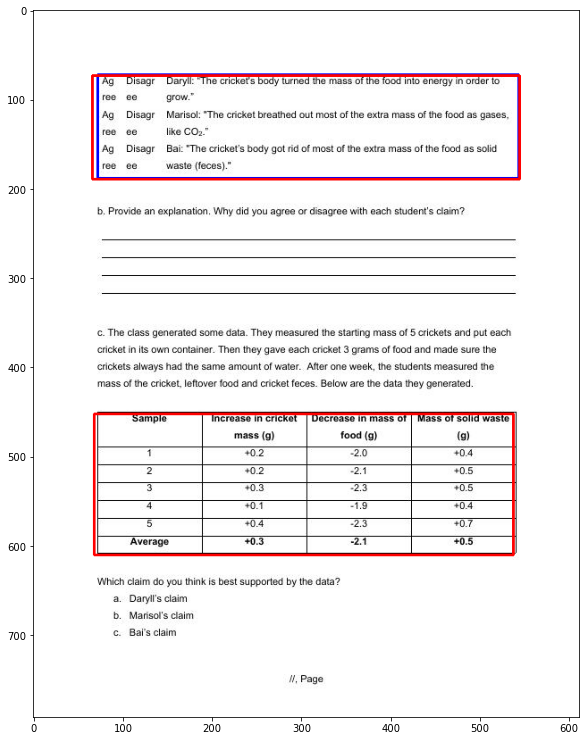

precision:  0.13312481861434675
image name:  /data/rali5/Tmp/yockelle/TableBank/TableBank/Detection/images/2017%20MET%20ATASKAITA_16.jpg


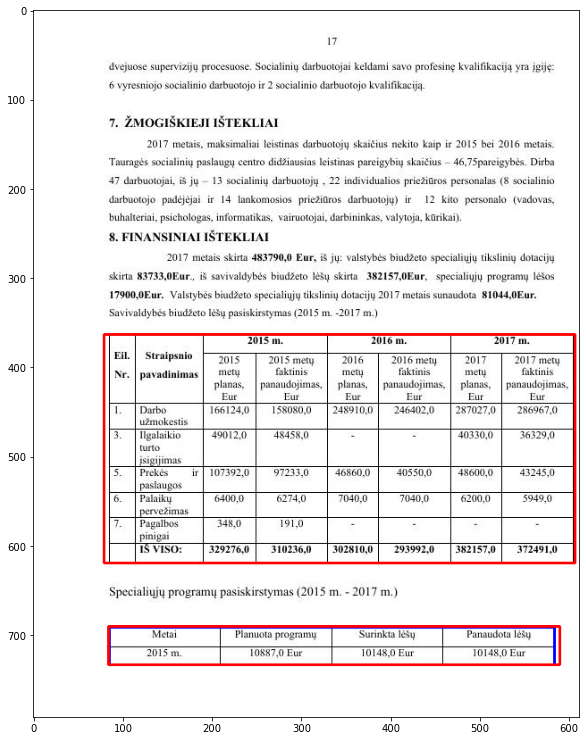

precision:  0.30824547808193825
image name:  /data/rali5/Tmp/yockelle/TableBank/TableBank/Detection/images/memoriadeltrabajodegradov7_49.jpg


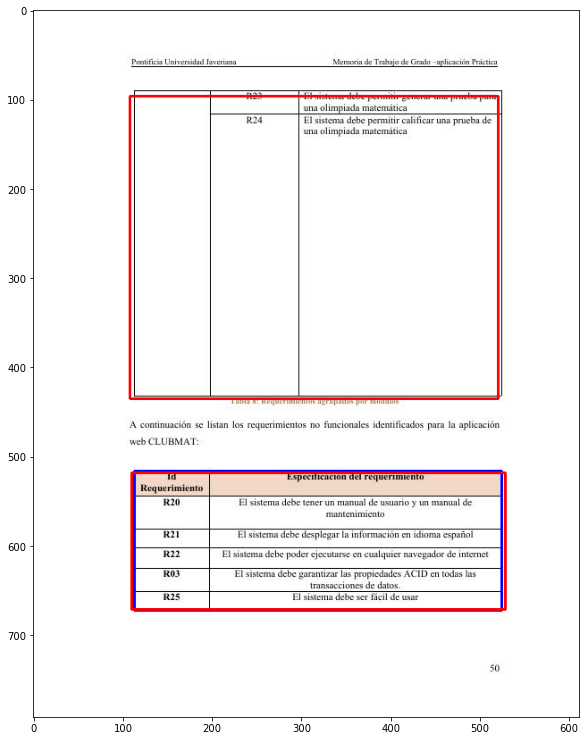

precision:  0.3184829547598506
image name:  /data/rali5/Tmp/yockelle/TableBank/TableBank/Detection/images/3_Obrazec_st._1_Prijavnica_Podpora_deleznikom_popravek_31.jpg


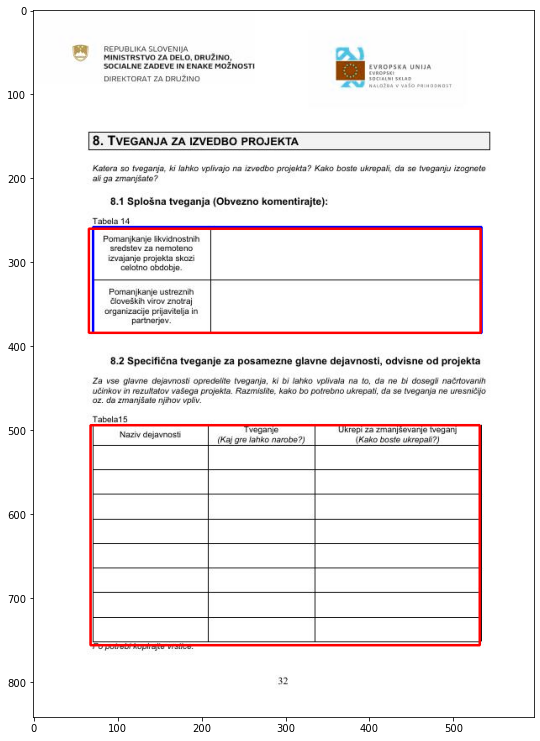

precision:  0.3374935966273792
image name:  /data/rali5/Tmp/yockelle/TableBank/TableBank/Detection/images/6031288037_99.jpg


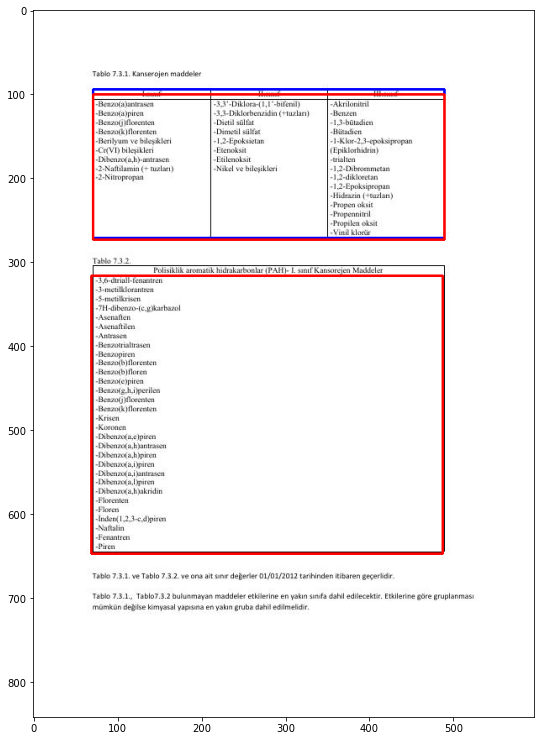

precision:  0.3173845333347213
image name:  /data/rali5/Tmp/yockelle/TableBank/TableBank/Detection/images/2018_U14B_Final_0.jpg


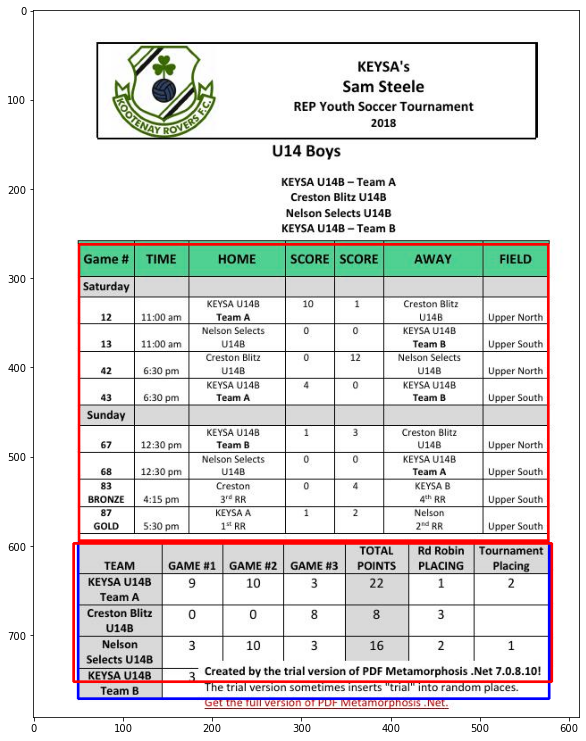

precision:  0.3176082339127231
image name:  /data/rali5/Tmp/yockelle/TableBank/TableBank/Detection/images/AC018MXSCCCAA_Guide%20Spec_29.jpg


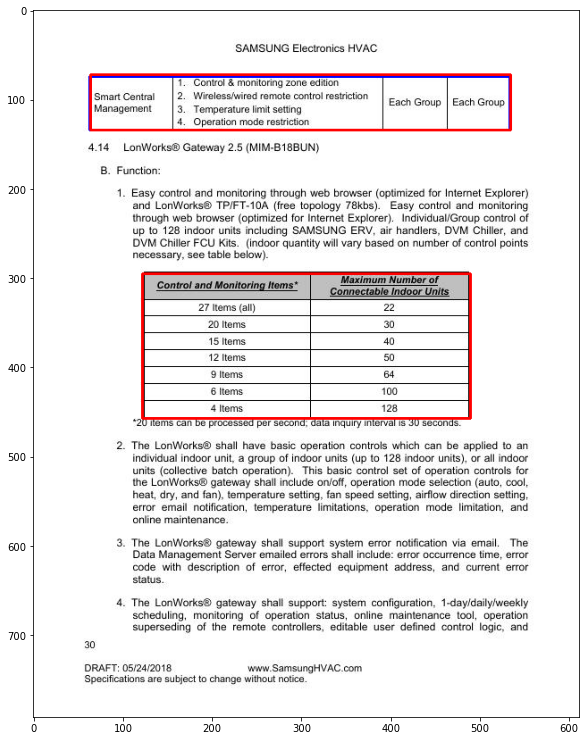

precision:  0.09283048848444254
image name:  /data/rali5/Tmp/yockelle/TableBank/TableBank/Detection/images/04070743_saitfaikilkokulu20152019strtejikplan1_46.jpg


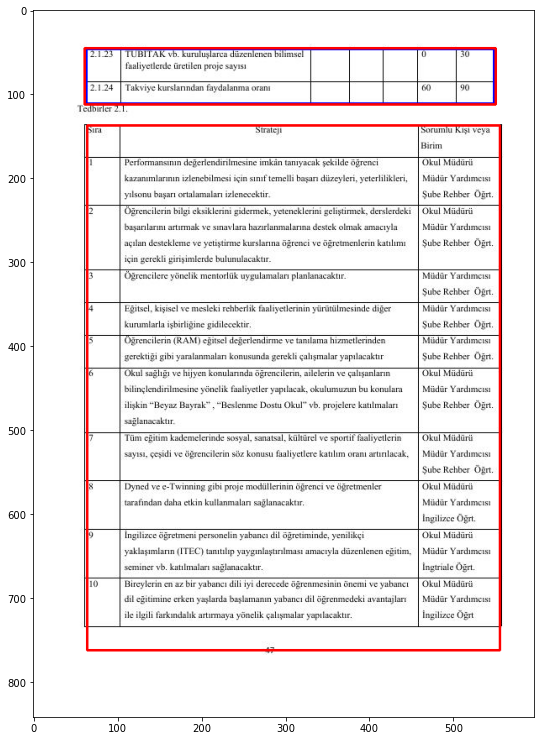

precision:  0.2528777526463308
image name:  /data/rali5/Tmp/yockelle/TableBank/TableBank/Detection/images/94817_eksempler-p-retningslinjer-for-sololgen-med-en-faggruppe-ansat-30_32.jpg


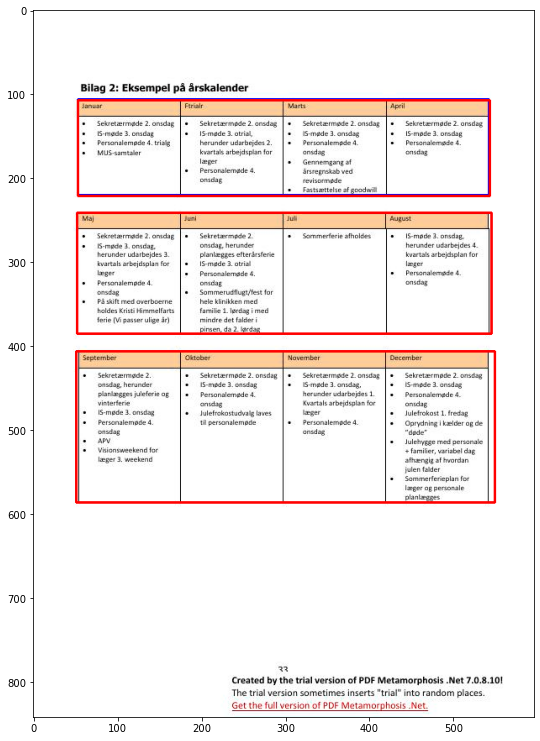

precision:  0.0
image name:  /data/rali5/Tmp/yockelle/TableBank/TableBank/Detection/images/best_final_benchmark_question_list_19.jpg


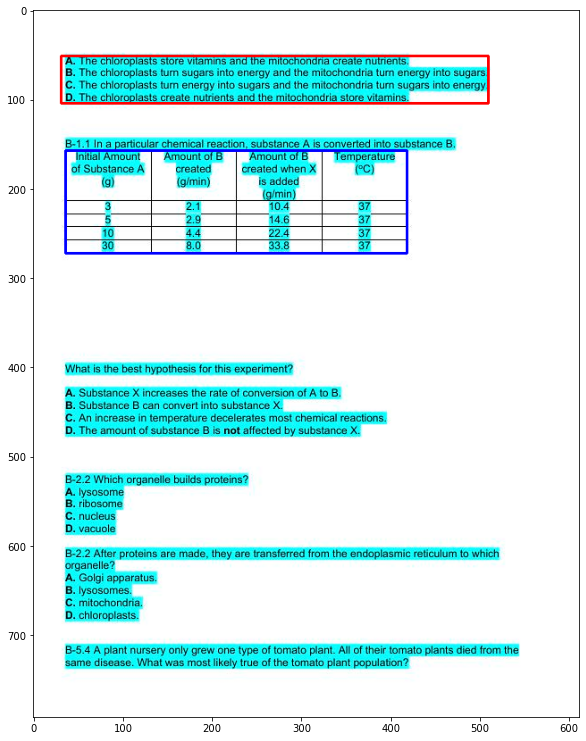

precision:  0.27875042932563504
image name:  /data/rali5/Tmp/yockelle/TableBank/TableBank/Detection/images/917442_2018%20MLK%20Invite%20Packet_4.jpg


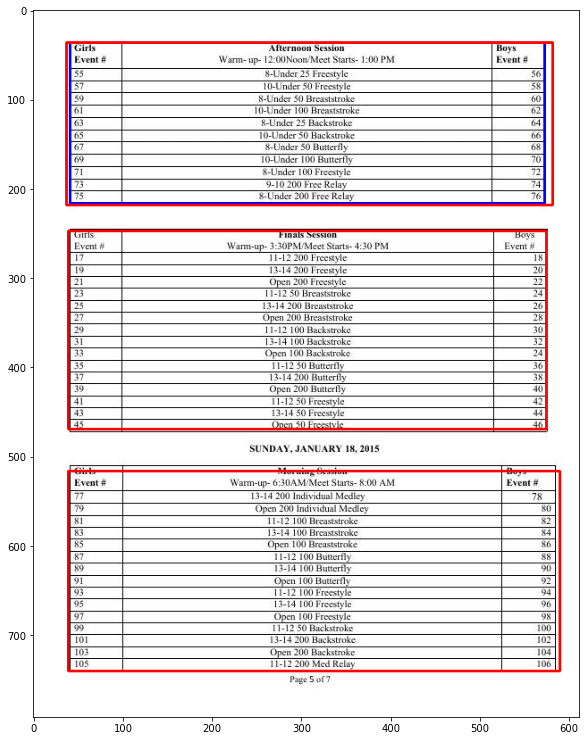

precision:  0.4624951963922833
image name:  /data/rali5/Tmp/yockelle/TableBank/TableBank/Detection/images/09092016120955_fks_7.jpg


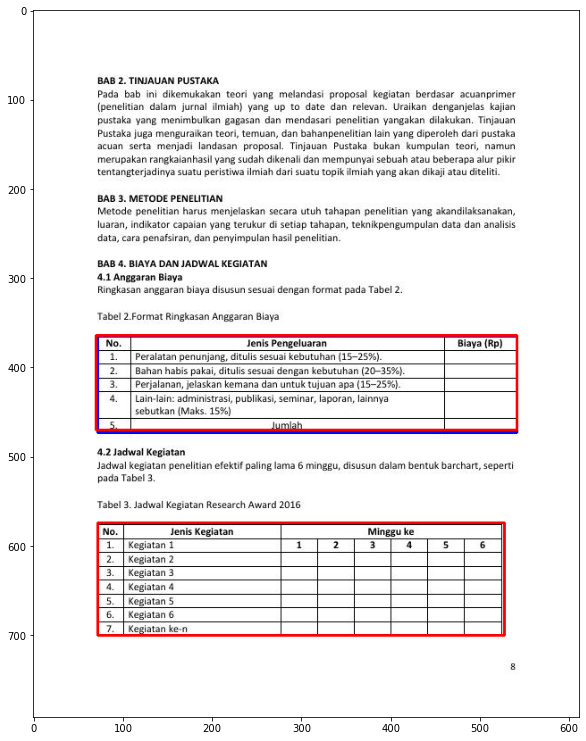

precision:  0.11332732634082152
image name:  /data/rali5/Tmp/yockelle/TableBank/TableBank/Detection/images/Vyrocnizprava2010-11doplnena_3.jpg


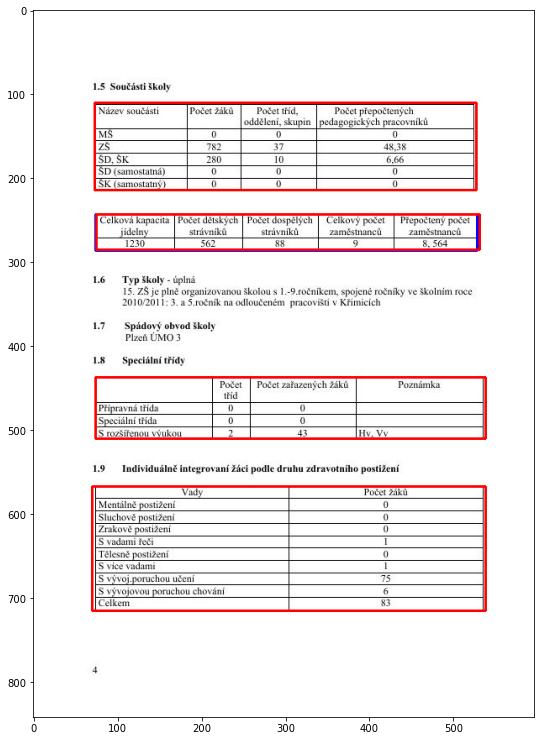

Precision  0.8841719208345457
Recall  0.9137961866804093
F1  0.8987400012842333
Number of bad precision:  21


In [15]:
#test_data = get_test_data_word()
#test_data_publaynet = get_test_data_latex()
test_type_name = "word-latex"
is_show_image = True

threshold = 0.975

precision_tab = []
recall_tab = []

sum_numerator = 0
sum_numerator_old = 0
sum_denominator_precision = 0
sum_denominator_recall = 0

test_count = 0

count_bad_precision = 0

test_data = []
if "word" in test_type_name:
  test_data.extend(get_test_data_word()[100:300])
if "latex" in test_type_name:
  test_data.extend(get_test_data_latex()[100:300])
if "publaynet" in test_type_name:
  test_data.extend(get_test_data_publaynet())

for i in range(len(test_data)):
  #if i%1000 == 0:
  #  print(i)
  image_dict = test_data[i]

  try: 
    image_name = "/data/rali5/Tmp/yockelle/TableBank/" + image_dict["file_name"]  
    im = cv2.imread(image_name)
    does_shape_work = im.shape
  except:
    image_name = image_dict["file_name"]
    im = cv2.imread(image_name)

  outputs = predictor(im)

  predictions_detectron = outputs["instances"].pred_boxes.tensor.cpu().numpy()
  scores_detectron = outputs["instances"].scores.cpu().numpy()
  predictions_with_threshold = []
  for j, p in enumerate(predictions_detectron):
    if scores_detectron[j]>threshold:
      predictions_with_threshold.append(p)
  predictions_with_threshold = np.array(predictions_with_threshold)

  # Get the ground truth
  bbox_ground_truth = []
  truth = image_dict["annotations"]
  for t in truth:
      x_min = t["bbox"][0]
      y_min = t["bbox"][1]
      w = t["bbox"][2]
      h = t["bbox"][3]
      x_max = x_min + w
      y_max = y_min + h
      bbox_ground_truth.append([x_min, y_min, x_max, y_max])

  result = metric_table_bank_union(bbox_ground_truth, predictions_with_threshold)

  if result != None:
    test_count += 1
    numerator, denominator_precision, denominator_recall, old_way_area_union = result

    sum_numerator += numerator
    sum_numerator_old += old_way_area_union
    sum_denominator_precision += denominator_precision
    sum_denominator_recall += denominator_recall

  if is_show_image:
    if denominator_precision>0:
      if numerator/denominator_precision <= 0.5:
        count_bad_precision += 1
        print("precision: ", numerator/denominator_precision)
        print("image name: ", image_name)
        draw_pred_and_truth(im, bbox_ground_truth, predictions_with_threshold)
        plt.figure(figsize = (13,13))
        plt.imshow(im)
        plt.show()


precision = sum_numerator/sum_denominator_precision
recall = sum_numerator/sum_denominator_recall
f1 = (2 * precision * recall) / (precision + recall)

print("Precision ", precision)
print("Recall ", recall)
print("F1 ", f1)
print("Number of bad precision: ", count_bad_precision)  

In [12]:
len(test_data)

8000

In [26]:
len(get_train_data_both())

260582

### Measure with tablebank metric

In [ ]:
train_possibilities = ["latex", "word-latex"] #["word", "latex", "word-latex"]
test_possibilities = ["word", "latex", "publaynet", "word-latex", "word-publaynet" , "latex-publaynet", "word-latex-publaynet"]
threshold = 0.975

for train_type_name in train_possibilities:
  type_ = "/" + train_type_name + "/"
  train_type = train_type_name

  cfg = get_cfg()
  cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
  #cfg.DATASETS.TRAIN = (train_set_name,)
  cfg.DATASETS.TEST = ()
  cfg.DATALOADER.NUM_WORKERS = 4
  cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR + type_, "model_final.pth")
  cfg.SOLVER.IMS_PER_BATCH = 4
  cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256
  cfg.MODEL.PANOPTIC_FPN.COMBINE.INSTANCES_CONFIDENCE_THRESH = 0.5
  cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
  cfg.TEST.EVAL_PERIOD = 1000
  CUDA_LAUNCH_BLOCKING = 1
  predictor = DefaultPredictor(cfg)

  for test_type_name in test_possibilities:
    print("TRAIN TYPE: ", train_type_name)
    print("TEST TYPE: ", test_type_name)

    test_latex_predictions = {}
    test_latex_truth = {}

    test_data = []

    if "word" in test_type_name:
      test_data.extend(get_test_data_word())
    if "latex" in test_type_name:
      test_data.extend(get_test_data_latex())
    if "publaynet" in test_type_name:
      test_data.extend(get_test_data_publaynet())

    count_pred = 0
    count_truth = 0

    sum_numerator = 0
    sum_numerator_old = 0
    sum_denominator_precision = 0
    sum_denominator_recall = 0

    for index, image_dict in enumerate(test_data):
      one_image_pred = {}
      one_image_truth = {}

      try: 
        image_name = "/data/rali5/Tmp/yockelle/TableBank/" + image_dict["file_name"]  
        im = cv2.imread(image_name).shape
      except:
        image_name = image_dict["file_name"]
        im = cv2.imread(image_name).shape
      #image_name = "/data/rali5/Tmp/yockelle/PubLayNet/" + image_dict["file_name"]
      #image_name = image_dict["file_name"]
      only_name = image_dict["file_name"].split("/")[-1]

      truths_boxes = []
      preds_boxes = []

      problem = False

      # ADD TRUTH
      for annot in image_dict["annotations"]:
        p = annot["bbox"]
        x1 = p[0]
        y1 = p[1]
        w = p[2]
        h = p[3]
        x2 = p[0] + w
        y2 = p[1] + h
        #if y1 == y2 or y2<y1:
        #  problem = True
        #  break

        #if not(problem):
        count_truth += 1
        truths_boxes.append([x1,y1,x2,y2])
      
      # ADD PREDS
      im = cv2.imread(image_name)
      outputs = predictor(im)
      predictions_detectron = outputs["instances"].pred_boxes.tensor.cpu().numpy()
      scores_detectron = outputs["instances"].scores.cpu().numpy()

      for j, p in enumerate(predictions_detectron):
        if scores_detectron[j]>threshold:
          x1 = p[0]
          y1 = p[1]
          x2 = p[2]
          y2 = p[3]
          w = x2-x1
          h = y2-y1
          count_pred += 1
          preds_boxes.append([x1,y1,x2,y2])

      result = metric_table_bank_union(np.array(truths_boxes), np.array(preds_boxes))
      numerator, denominator_precision, denominator_recall, old_way_area_union = result

      sum_numerator += numerator
      sum_numerator_old += old_way_area_union
      sum_denominator_precision += denominator_precision
      sum_denominator_recall += denominator_recall

    precision = sum_numerator/sum_denominator_precision
    recall = sum_numerator/sum_denominator_recall
    f1 = (2 * precision * recall) / (precision + recall)

    print("Precision ", precision)
    print("Recall ", recall)
    print("F1 ", f1)
    print("-----------------------------------------------------")

### Measure for all metrics

In [ ]:
train_possibilities = ["word"]
test_possibilities = ["word", "latex", "word-latex"] #"word-publaynet" , "latex-publaynet", "word-latex-publaynet"]
#test_possibilities = ["publaynet"]

for train_type_name in train_possibilities:

  type_ = "/" + train_type_name + "/"
  train_type = train_type_name

  cfg = get_cfg()
  cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
  #cfg.DATASETS.TRAIN = (train_set_name,)
  cfg.DATASETS.TEST = ()
  cfg.DATALOADER.NUM_WORKERS = 4
  cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR + type_, "model_final.pth")
  cfg.SOLVER.IMS_PER_BATCH = 4
  cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256
  cfg.MODEL.PANOPTIC_FPN.COMBINE.INSTANCES_CONFIDENCE_THRESH = 0.5
  cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
  cfg.TEST.EVAL_PERIOD = 1000
  CUDA_LAUNCH_BLOCKING = 1
  predictor = DefaultPredictor(cfg)

  for test_type_name in test_possibilities:
    print(test_type_name)

    test_latex_predictions = {}
    test_latex_truth = {}

    test_data = []

    if "word" in test_type_name:
      test_data.extend(get_test_data_word())
    if "latex" in test_type_name:
      test_data.extend(get_test_data_latex())
    if "publaynet" in test_type_name:
      test_data.extend(get_test_data_publaynet())

    test_type = test_type_name
    
    count_pred = 0
    count_truth = 0

    all_image_preds = []
    all_annotations_preds = []

    all_image_truth = []
    all_annotations_truth = []

    sum_numerator = 0
    sum_numerator_old = 0
    sum_denominator_precision = 0
    sum_denominator_recall = 0

    for index, image_dict in enumerate(test_data):
      one_image_pred = {}
      one_image_truth = {}
      
      #if index%500 == 0:
      #  print(index)

      try: 
        image_name = "/data/rali5/Tmp/yockelle/TableBank/" + image_dict["file_name"]  
        im = cv2.imread(image_name).shape
      except:
        image_name = image_dict["file_name"]
        im = cv2.imread(image_name).shape
      #image_name = "/data/rali5/Tmp/yockelle/PubLayNet/" + image_dict["file_name"]
      #image_name = image_dict["file_name"]
      only_name = image_dict["file_name"].split("/")[-1]

      truths_boxes = []
      preds_boxes = []

      problem = False

      # ADD TRUTH
      for annot in image_dict["annotations"]:
        #if scores_detectron[j]>threshold:
        p = annot["bbox"]
        x1 = p[0]
        y1 = p[1]
        w = p[2]
        h = p[3]
        x2 = p[0] + w
        y2 = p[1] + h
        if y1 == y2 or y2<y1:
          #print("here")
          #print(count_truth)
          problem = True
          break

        if not(problem):
          
          one_annotations = {}
          one_annotations["id"] = count_truth
          one_annotations["segmentation"] = []
          one_annotations["area"] = float(w * h)
          one_annotations["iscrowd"] = 0
          one_annotations["ignore"] = 0
          one_annotations["image_id"] = index
          one_annotations["bbox"] = [float(pp) for pp in p]
          one_annotations["category_id"] = 0

          all_annotations_truth.append(one_annotations)
          count_truth += 1

          truths_boxes.append([x1,y1,x2,y2])

      if problem:
        continue

      if problem:
        print("wtf")

      one_image_truth["id"] = index
      one_image_truth["file_name"] = only_name
      one_image_truth["width"] = image_dict["width"]
      one_image_truth["height"] = image_dict["height"]

      all_image_truth.append(one_image_truth)
      

      # ADD PREDS
      im = cv2.imread(image_name)
      outputs = predictor(im)
      predictions_detectron = outputs["instances"].pred_boxes.tensor.cpu().numpy()
      scores_detectron = outputs["instances"].scores.cpu().numpy()

      for j, p in enumerate(predictions_detectron):
        #if scores_detectron[j]>threshold:
        x1 = p[0]
        y1 = p[1]
        x2 = p[2]
        y2 = p[3]
        w = x2-x1
        h = y2-y1
        #x2 = p[0] + w
        #y2 = p[1] + h
        
        one_annotations = {}
        one_annotations["id"] = count_pred
        one_annotations["segmentation"] = []
        one_annotations["area"] = float(w * h)
        one_annotations["iscrowd"] = 0
        one_annotations["ignore"] = 0
        one_annotations["image_id"] = index
        one_annotations["bbox"] = [float(pp) for pp in [x1,y1,w,h]]
        one_annotations["category_id"] = 0
        one_annotations["score"] = float(scores_detectron[j])

        all_annotations_preds.append(one_annotations)
        count_pred += 1

        preds_boxes.append([x1,y1,x2,y2])

      one_image_pred["id"] = index
      one_image_pred["file_name"] = only_name
      one_image_pred["width"] = image_dict["width"]
      one_image_pred["height"] = image_dict["height"]

      all_image_preds.append(one_image_pred)

      result = metric_table_bank_union(np.array(truths_boxes), np.array(preds_boxes))
      numerator, denominator_precision, denominator_recall, old_way_area_union = result

      sum_numerator += numerator
      sum_numerator_old += old_way_area_union
      sum_denominator_precision += denominator_precision
      sum_denominator_recall += denominator_recall


    # ADD TRUTHS
    test_latex_truth["images"] = all_image_truth
    test_latex_truth["annotations"] = all_annotations_truth
    test_latex_truth["categories"] = [{"id": 0, "name": "table", "supercategory": "none"}]

    path_truth = "prediction_and_truth_my_models/train_"+train_type+"/annotations_test_"+test_type+"/truth"
    if not path.exists(path_truth):
      os.makedirs(path_truth)
    out_file = open(path_truth + "/test_"+test_type+"_truth.json", "w")
    json.dump(test_latex_truth, out_file, indent = 6)
    out_file.close()
      
    # ADD PREDS
    test_latex_predictions["images"] = all_image_preds
    test_latex_predictions["annotations"] = all_annotations_preds
    test_latex_predictions["categories"] = [{"id": 0, "name": "table", "supercategory": "none"}]

    path_pred = "prediction_and_truth_my_models/train_"+train_type+"/annotations_test_"+test_type+"/preds"
    if not path.exists(path_pred):
      os.makedirs(path_pred)
    out_file = open(path_pred + "/test_"+test_type+"_preds.json", "w")
    json.dump(test_latex_predictions, out_file, indent = 6)
    out_file.close()

    precision = sum_numerator/sum_denominator_precision
    recall = sum_numerator/sum_denominator_recall
    f1 = (2 * precision * recall) / (precision + recall)

    print("First")
    print("Precision ", precision)
    print("Recall ", recall)
    print("F1 ", f1)

In [ ]:
'''
test_latex_predictions = {}

test_data = get_test_data_latex()

threshold = 0.975
precision_tab = []
count = 0

all_image = []
all_annotations = []

for i, image_dict in enumerate(test_data):
  one_image = {}
  

  if i%1000 == 0:
    print(i)

  image_dict = test_data[i]
  image_name = "/data/rali5/Tmp/yockelle/TableBank/" + image_dict["file_name"]  
  #image_name = "/data/rali5/Tmp/yockelle/PubLayNet/" + image_dict["file_name"]
  #image_name = image_dict["file_name"]
  only_name = image_dict["file_name"].split("/")[-1]
  im = cv2.imread(image_name)
  outputs = predictor(im)

  predictions_detectron = outputs["instances"].pred_boxes.tensor.cpu().numpy()
  scores_detectron = outputs["instances"].scores.cpu().numpy()

  for j, p in enumerate(predictions_detectron):
    #if scores_detectron[j]>threshold:
    one_annotations = {}
    one_annotations["id"] = count
    one_annotations["segmentation"] = []
    one_annotations["area"] = float(p[-1] * p[-2])
    one_annotations["iscrowd"] = 0
    one_annotations["ignore"] = 0
    one_annotations["image_id"] = i
    one_annotations["bbox"] = [float(pp) for pp in p]
    one_annotations["category_id"] = 0
    one_annotations["score"] = float(scores_detectron[j])

    all_annotations.append(one_annotations)
    count += 1

  one_image["id"] = i
  one_image["file_name"] = only_name
  one_image["width"] = image_dict["width"]
  one_image["height"] = image_dict["height"]

  all_image.append(one_image)
  

test_latex_predictions["images"] = all_image
test_latex_predictions["annotations"] = all_annotations
test_latex_predictions["categories"] = [{"id": 0, "name": "table", "supercategory": "none"}]

out_file = open("train_latex_test_latex_preds.json", "w")
json.dump(test_latex_predictions, out_file, indent = 6)
out_file.close()
'''


In [ ]:
"""
test_latex_predictions = []

test_data = get_test_data_latex()

threshold = 0.975
precision_tab = []
count = 0

for i, image_dict in enumerate(test_data):
  pred_for_one_image = {}

  if i%1000 == 0:
    print(i)

  image_dict = test_data[i]
  image_name = "/data/rali5/Tmp/yockelle/TableBank/" + image_dict["file_name"]
  #image_name = "/data/rali5/Tmp/yockelle/PubLayNet/" + image_dict["file_name"]
  im = cv2.imread(image_name)
  outputs = predictor(im)

  predictions_detectron = outputs["instances"].pred_boxes.tensor.cpu().numpy()
  scores_detectron = outputs["instances"].scores.cpu().numpy()

  track = []

  for j, p in enumerate(predictions_detectron):
    #if scores_detectron[j]>threshold:
    one_track = {}
    one_track["frame"] = count
    one_track["bbox"] = list(p)
    one_track["confidence"] = str(scores_detectron[j])
    track.append(one_track)
    count += 1

  pred_for_one_image["id"] = i
  pred_for_one_image["video_id"] = i
  pred_for_one_image["category_id"] = 0
  pred_for_one_image["index"] = track

  test_latex_predictions.append(pred_for_one_image)

out_file = open("train_latex_test_latex.json", "w")
json.dump(test_latex_predictions, out_file, indent = 6)
out_file.close()
"""


# Make Precision-Recall curve

In [ ]:
test_data = get_test_data_both()
#threshold_pred = [0.0, 0.6, 0.8, 0.95, 0.97, 0.99]

threshold_pred = [0.975, 0.98, 0.985]

recall_with_threshold = []
precision_with_threshold = []

for threshold_ind, threshold in enumerate(threshold_pred):
  print(threshold)

  precision_tab = []
  recall_tab = []

  sum_numerator = 0
  sum_numerator_old = 0
  sum_denominator_precision = 0
  sum_denominator_recall = 0

  test_count = 0

  for i in range(len(test_data)):
    if i%4000 == 0:
      print(i)
    image_dict = test_data[i]
    image_name = "/data/rali5/Tmp/yockelle/TableBank/" + image_dict["file_name"]
    im = cv2.imread(image_name)
    outputs = predictor(im)

    predictions_detectron = outputs["instances"].pred_boxes.tensor.cpu().numpy()
    scores_detectron = outputs["instances"].scores.cpu().numpy()
    predictions_with_threshold = []
    for j, p in enumerate(predictions_detectron):
      if scores_detectron[j]>threshold:
        predictions_with_threshold.append(p)
    predictions_with_threshold = np.array(predictions_with_threshold)

    # Get the ground truth
    bbox_ground_truth = []
    truth = image_dict["annotations"]
    for t in truth:
        x_min = t["bbox"][0]
        y_min = t["bbox"][1]
        w = t["bbox"][2]
        h = t["bbox"][3]
        x_max = x_min + w
        y_max = y_min + h
        bbox_ground_truth.append([x_min, y_min, x_max, y_max])

    result = metric_table_bank_union(bbox_ground_truth, predictions_with_threshold)

    if result != None:
      test_count += 1
      numerator, denominator_precision, denominator_recall, old_way_area_union = result

      #precision_tab.append(precision)
      #recall_tab.append(recall)

      sum_numerator += numerator
      sum_numerator_old += old_way_area_union
      sum_denominator_precision += denominator_precision
      sum_denominator_recall += denominator_recall

  precision = sum_numerator/sum_denominator_precision
  recall = sum_numerator/sum_denominator_recall
  f1 = (2 * precision * recall) / (precision + recall)

  precision_with_threshold.append(precision)
  recall_with_threshold.append(recall)

  #precision_old = sum_numerator_old/sum_denominator_precision
  #recall_old = sum_numerator_old/sum_denominator_recall
  #f1_old = (2 * precision_old * recall_old) / (precision_old + recall_old)

  print("precision ", precision)
  print("recall ", recall)
  print("f1 ", f1)

with open('X101model_recall_with_threshold_latex-word_0.975_0.98_0.985.pkl', 'wb') as f:
  pickle.dump(recall_with_threshold, f)

with open('X101model_precision_with_threshold_latex-word_0.975_0.98_0.985.pkl', 'wb') as f:
    pickle.dump(precision_with_threshold, f)


In [ ]:
with open('image_curve/v2_recall_with_threshold_latex-word.pkl', 'rb') as f:
    recall_with_threshold = pickle.load(f)

with open('image_curve/v2_precision_with_threshold_latex-word.pkl', 'rb') as f:
    precision_with_threshold = pickle.load(f)

In [ ]:
recall = recall_with_threshold[6]
precision = precision_with_threshold[6]

print((2 * precision * recall) / (precision + recall))

In [ ]:
with open('image_curve/X101model_recall_with_threshold_latex-word.pkl', 'rb') as f:
    recall_with_threshold = pickle.load(f)

with open('image_curve/X101model_precision_with_threshold_latex-word.pkl', 'rb') as f:
    precision_with_threshold = pickle.load(f)

threshold_pred = [0.0, 0.6, 0.8, 0.95, 0.97, 0.975, 0.98, 0.985, 0.99]

plt.figure(figsize=(13, 9))

plt.rcParams['text.usetex']=True
plt.rc({
    "font.family": "serif",
    "font.serif": ["Palatino"]})

colors_choices = ["#f81aa1", "#3cc84b", "#6a2020", "#ff8d00", "#ff0000", "#bc21e9", "#1798e7", "#09701d", "#2af0f0"]

plt.plot(recall_with_threshold, precision_with_threshold, '--', color="k")

for thresh_ind, threshold in enumerate(threshold_pred):
  plt.plot(recall_with_threshold[thresh_ind], precision_with_threshold[thresh_ind], 'o', markersize=10, color=colors_choices[thresh_ind], label=threshold)

plt.plot(0.8817, 0.9670, 'o', markersize=10, color="k", label="paper")

plt.grid()
plt.xlabel('Recall', fontsize=15)
plt.ylabel('Precision', fontsize=15)
plt.xticks(fontsize = 17)
plt.yticks(fontsize = 17)
#plt.xlim(min(recall_with_threshold)-0.009, 1.0)
#plt.ylim(min(precision_with_threshold)-0.02, 1.0)
plt.legend(prop={'size': 14}, title="Prediction threshold", title_fontsize=14)
plt.savefig("X101model-precision_latex-word.png")
plt.show()


In [ ]:
test_data = get_test_data_both()

precision_tab = []
recall_tab = []

sum_numerator = 0
sum_denominator_precision = 0
sum_denominator_recall = 0

test_count = 0

for i in  range(len(test_data)):
  if not i%100:
    print(i)

  image_dict = test_data[i]
  image_name = "/data/rali5/Tmp/yockelle/TableBank/" + image_dict["file_name"]
  im = cv2.imread(image_name)
  outputs = predictor(im)

  predictions_detectron = outputs["instances"].pred_boxes.tensor.cpu().numpy()

  # Get the ground truth
  bbox_ground_truth = []
  truth = image_dict["annotations"]
  for t in truth:
      x_min = t["bbox"][0]
      y_min = t["bbox"][1]
      w = t["bbox"][2]
      h = t["bbox"][3]
      x_max = x_min + w
      y_max = y_min + h
      bbox_ground_truth.append([x_min, y_min, x_max, y_max])

  result = measure_metric_table_bank(bbox_ground_truth, predictions_detectron)

  if result != None:
    test_count += 1
    precision, recall, numerator, denominator_precision, denominator_recall = result

    #precision_tab.append(precision)
    #recall_tab.append(recall)

    sum_numerator += numerator
    sum_denominator_precision += denominator_precision
    sum_denominator_recall += denominator_recall

precision = sum_numerator/sum_denominator_precision
recall = sum_numerator/sum_denominator_recall
f1 = (2 * precision * recall) / (precision + recall)
print(sum_numerator)
print(sum_denominator_precision)
print(sum_denominator_recall)

In [ ]:
print("Old way with only intersect")
print("precision ", precision)
print("recall ", recall)
print("f1 ", f1)